# Exporting DeePTB Models to External Tools

DeePTB not only provides its own powerful training and analysis tools but also allows you to export your trained tight-binding models to popular external formats. This opens up compatibility with a vast ecosystem of post-processing tools.

In this tutorial, we will demonstrate:
1. Exporting a DeePTB model directly to a **PythTB** model object for interactive analysis.

## Prerequisites

Ideally, you should have `dptb` installed. For the PythTB section, you will need `pythtb` installed (`uv sync --extra pythtb` or `uv run pip install pythtb` or `pip install pythtb`).

In [203]:
import os
import torch
from dptb.nn import build_model
from dptb.data import AtomicData
from ase.io import read
from dptb.postprocess.interfaces import ToWannier90, ToPythTB
import matplotlib.pyplot as plt
import numpy as np
from dptb.postprocess.bandstructure.band import Band


In [262]:
# Define paths to example data (adjust if running elsewhere)
root_dir = os.path.abspath(".") # Assuming running from root dir of DeePTB package.
model_path = os.path.join(root_dir, "models", "mix.iter200.pth")
struct_path = os.path.join(root_dir, "silicon.vasp")
model = build_model(model_path)
model.eval()

The model option atomic_radius in nnsk is not defined in input model_options, set to v1.


MIX(
  (nnenv): NNENV(
    (embedding): SE2Descriptor(
      (onehot): OneHotAtomEncoding()
      (descriptor): _SE2Descriptor()
    )
    (node_prediction_h): AtomicResNet(
      (layers): ModuleList(
        (0): AtomicResBlock(
          (layer): AtomicMLP(
            (in_layer): Linear(in_features=900, out_features=16, bias=True)
            (out_layer): Linear(in_features=16, out_features=16, bias=True)
          )
        )
      )
      (out_layer): AtomicLinear(
        (linear): Linear(in_features=16, out_features=3, bias=True)
      )
    )
    (edge_prediction_h): AtomicResNet(
      (layers): ModuleList(
        (0): AtomicResBlock(
          (layer): AtomicMLP(
            (in_layer): Linear(in_features=901, out_features=16, bias=True)
            (out_layer): Linear(in_features=16, out_features=16, bias=True)
          )
        )
      )
      (out_layer): AtomicLinear(
        (linear): Linear(in_features=16, out_features=10, bias=True)
      )
    )
    (hamiltonian):

## 1. Use DeePTB band plot to get the band structure of the model.

eig_solver is not set, using default 'torch'.


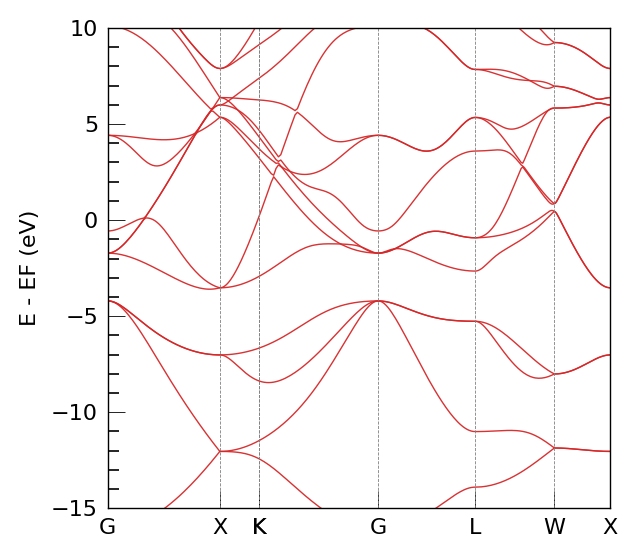

In [263]:
jdata={   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,   50],   
                [0.5000000000,   0.0000000000,   0.5000000000,   50],               
                [0.6250000000,   0.2500000000,   0.6250000000,   1],    
                [0.3750000000,   0.3750000000,   0.7500000000,   50],     
                [0.0000000000,   0.0000000000,   0.0000000000,   50],    
                [0.5000000000,   0.5000000000,   0.5000000000,   50],                
                [0.5000000000,   0.2500000000,   0.7500000000,   50],               
                [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "nel_atom":{"Si":4},
        "E_fermi":-4.722,
        "emin":-15,
        "emax":10,
        "ref_band": "./data/kpath.0/eigenvalues.npy"
    }
}
kpath_kwargs = jdata["task_options"]
stru_data = "silicon.vasp"
bcal = Band(model=model, 
            use_gui=True, 
            device=model.device)
eigens = bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs)
bcal.band_plot(ref_band = None,
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

## 2. Export to PythTB

PythTB is a lightweight tight-binding solver in Python. We can convert our DeePTB model directly into a `pythtb` model object.

Model converted to PythTB!
----- k_path report begin ----------
real-space lattice vectors
 [[0.    2.715 2.715]
 [2.715 0.    2.715]
 [2.715 2.715 0.   ]]
k-space metric tensor
 [[ 0.10175 -0.03392 -0.03392]
 [-0.03392  0.10175 -0.03392]
 [-0.03392 -0.03392  0.10175]]
internal coordinates of nodes
 [[0.    0.    0.   ]
 [0.5   0.    0.5  ]
 [0.625 0.25  0.625]
 [0.375 0.375 0.75 ]
 [0.    0.    0.   ]
 [0.5   0.5   0.5  ]
 [0.5   0.25  0.75 ]
 [0.5   0.    0.5  ]]
reciprocal-space lattice vectors
 [[-0.18416  0.18416  0.18416]
 [ 0.18416 -0.18416  0.18416]
 [ 0.18416  0.18416 -0.18416]]
cartesian coordinates of nodes
 [[0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 1.84162e-01 0.00000e+00]
 [4.60405e-02 1.84162e-01 4.60405e-02]
 [1.38122e-01 1.38122e-01 6.93889e-18]
 [0.00000e+00 0.00000e+00 0.00000e+00]
 [9.20810e-02 9.20810e-02 9.20810e-02]
 [9.20810e-02 1.84162e-01 6.93889e-18]
 [0.00000e+00 1.84162e-01 0.00000e+00]]
list of segments:
  length = 0.18416  from  [0. 0. 0.]  to  

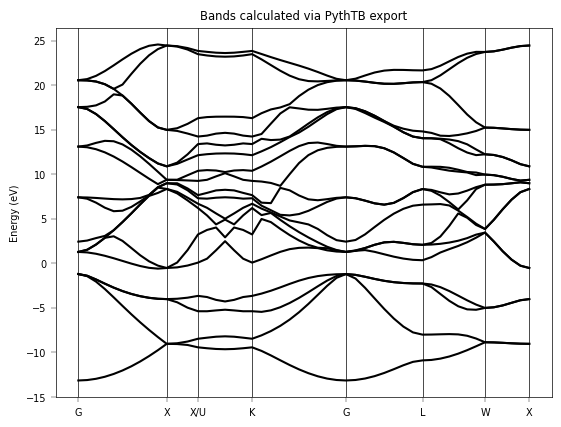

In [264]:
try:
    import pythtb
    
    # Initialize Converter
    pythtb_converter = ToPythTB(model, device="cpu")
    
    # Convert
    # providing e_fermi shifts the onsite energies
    my_tb_model = pythtb_converter.get_model(struct_path, e_fermi=-7.72)
    
    print("Model converted to PythTB!")
    print(my_tb_model)
    # Solve and Plot Bands
    path = [[0.0000000000,   0.0000000000,   0.0000000000],   
            [0.5000000000,   0.0000000000,   0.5000000000],               
            [0.6250000000,   0.2500000000,   0.6250000000],    
            [0.3750000000,   0.3750000000,   0.7500000000],     
            [0.0000000000,   0.0000000000,   0.0000000000],    
            [0.5000000000,   0.5000000000,   0.5000000000],                
            [0.5000000000,   0.2500000000,   0.7500000000],               
            [0.5000000000,   0.0000000000,   0.5000000000]
            ]

    labels = ["G","X","X/U","K","G","L","W","X"]
    
    (k_vec, k_dist, k_node) = my_tb_model.k_path(path, 50)
    evals = my_tb_model.solve_all(k_vec)
    
    fig, ax = plt.subplots()
    for band in evals:
        ax.plot(k_dist, band, color='k')
        
    for n in k_node:
        ax.axvline(n, linewidth=0.5, color='k')
    ax.set_xticks(k_node)
    ax.set_xticklabels(labels)
    ax.set_title("Bands calculated via PythTB export")
    ax.set_ylabel("Energy (eV)")
    plt.show()
    
except ImportError:
    print("PythTB not installed. Skipping this section.")

In [265]:
evals = my_tb_model.solve_all(eigens['klist'])

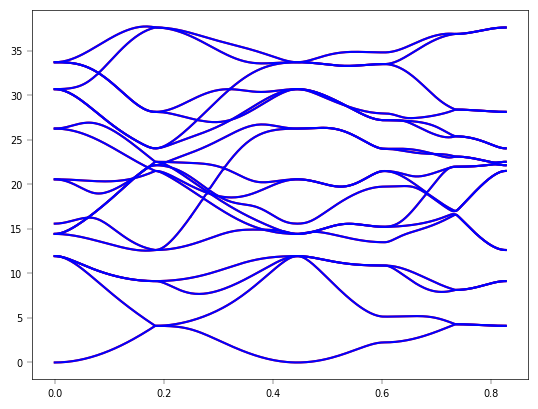

In [266]:
refeig = evals[:,:].T
plt.plot(eigens['xlist'],refeig - refeig.min() ,'r')
plt.plot(eigens['xlist'],eigens['eigenvalues']-eigens['eigenvalues'].min(),'b')
plt.show()


In [13]:
from dptb.postprocess.common import load_data_for_model
from dptb.data import AtomicData, AtomicDataDict, block_to_feature

# Use centralized data loading
data = load_data_for_model(
            data='./silicon.vasp',
            model=model)

In [15]:
data[AtomicDataDict.KPOINT_KEY] = \
            torch.nested.as_nested_tensor([torch.as_tensor([k_point], dtype=model.dtype, device=model.device)])
data = model(data)



In [19]:
data = bcal.eigv.h2k(data)

In [21]:
bcal.eigv.h_out_field

'hamiltonian'

In [26]:
hk1 = data['hamiltonian'][0]

In [28]:
H_k

array([[-3.58872711e+00+0.j,  7.26656926e-08+0.j,  7.61473551e-10+0.j,
        -4.09533287e-08+0.j,  1.46971223e-07+0.j,  0.00000000e+00+0.j,
        -2.42143869e-07+0.j, -2.89734436e-09+0.j,  2.98858271e-08+0.j,
        -1.22743036e+01+0.j,  0.00000000e+00+0.j,  4.91738319e-07+0.j,
         7.33416528e-09+0.j,  2.18977220e-07+0.j,  0.00000000e+00+0.j,
         5.16639489e-07+0.j, -5.82076609e-11+0.j,  9.79663528e-08+0.j],
       [ 7.26656926e-08+0.j,  3.37846402e+00+0.j,  1.77635684e-15+0.j,
        -8.90945866e-08+0.j,  8.47037368e-08+0.j,  1.49187491e-07+0.j,
        -8.29990076e-08+0.j,  0.00000000e+00+0.j, -1.46864121e-07+0.j,
         0.00000000e+00+0.j,  2.59604846e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j, -7.74161890e-08+0.j,  1.83106749e-07+0.j,
         0.00000000e+00+0.j, -3.42120222e+00+0.j,  0.00000000e+00+0.j],
       [ 7.61473551e-10+0.j,  1.77635684e-15+0.j,  3.37846408e+00+0.j,
         1.02181730e-09+0.j,  0.00000000e+00+0.j, -1.43515789e-07+0.j,
    

In [27]:
hk1

tensor([[-1.2755e+01+0.j,  1.2671e-07+0.j, -1.4901e-08+0.j,  5.9605e-08+0.j,
          1.3059e-07+0.j, -1.0637e-08+0.j, -2.3842e-07+0.j,  0.0000e+00+0.j,
          2.9802e-08+0.j, -1.2274e+01+0.j, -2.1607e-07+0.j,  2.1607e-07+0.j,
          2.7940e-08+0.j,  4.1723e-07+0.j,  8.9407e-08+0.j,  4.9919e-07+0.j,
          5.2154e-08+0.j,  7.4186e-08+0.j],
        [ 1.2671e-07+0.j, -2.3617e+00+0.j,  1.9365e-09+0.j, -7.3467e-08+0.j,
          1.6391e-07+0.j,  2.0862e-07+0.j, -1.3126e-07+0.j,  1.4211e-14+0.j,
         -1.0230e-07+0.j,  2.1420e-07+0.j,  2.5960e+00+0.j,  9.9652e-08+0.j,
         -1.6135e-07+0.j, -7.7300e-08+0.j,  1.9372e-07+0.j, -2.9802e-08+0.j,
         -3.4212e+00+0.j,  0.0000e+00+0.j],
        [-1.4901e-08+0.j,  1.9365e-09+0.j, -2.3617e+00+0.j,  0.0000e+00+0.j,
          1.4211e-14+0.j, -2.0603e-07+0.j, -3.1781e-07+0.j,  1.4901e-07+0.j,
          0.0000e+00+0.j,  1.2144e-06+0.j,  9.9652e-08+0.j,  2.5960e+00+0.j,
          1.6391e-07+0.j, -3.4212e+00+0.j, -1.4901e-08+0.j, -1.56

In [51]:
from dptb.postprocess.common import load_data_for_model
from dptb.data import AtomicData, AtomicDataDict, block_to_feature
from dptb.data.interfaces.ham_to_feature import feature_to_block
from pythtb import tb_model
# Use centralized data loading
data = load_data_for_model(
            data='./silicon.vasp',
            model=model)
data = model(data)

In [235]:
data2 = load_data_for_model(
            data='./silicon.vasp',
            model=model)
data2 = model.idp(data)
data2 = model(data)


In [13]:
blocks = feature_to_block(data, idp=model.idp)

In [15]:
blocks.keys()

dict_keys(['0_0_0_0_0', '1_1_0_0_0', '0_1_0_1_0', '0_0_0_1_0', '0_1_-1_1_0', '0_0_-1_1_0', '0_1_-2_1_0', '0_0_1_-1_1', '0_1_0_-1_1', '0_0_0_-1_1', '0_1_-1_-1_1', '0_0_-1_-1_1', '0_1_0_-2_1', '0_1_1_0_0', '0_0_1_0_0', '0_1_-1_0_0', '0_1_-2_0_0', '0_1_1_-1_0', '0_1_0_-1_0', '0_1_-1_-1_0', '0_1_1_-2_0', '0_1_0_-2_0', '0_1_0_1_-1', '0_0_-1_1_1', '0_1_0_0_1', '0_0_0_0_1', '0_1_-1_0_1', '0_0_-1_0_1', '0_1_-2_0_1', '0_1_0_0_0', '0_1_1_-1_-1', '0_1_1_0_-2', '0_1_0_-1_-1', '0_1_0_0_-2', '0_1_0_1_-2', '0_1_-1_1_-1', '0_1_0_0_-1', '0_1_-1_0_-1', '0_1_1_0_-1', '1_1_-1_1_1', '1_1_0_-1_0', '1_1_1_-1_0', '1_1_1_0_0', '1_1_1_0_-1', '1_1_0_1_-1', '1_1_-1_1_-1', '1_1_1_1_-1', '1_1_0_0_-1'])

In [ ]:
onsite_bonds = []
hop_bonds = []
for ibond in blocks.keys():
    ijRs = [int(ii) for ii in ibond.split("_")]
    # onsites:
    if ijRs[2:] == [0,0,0] and ijRs[0] == ijRs[1]:
        onsite_bonds.append(ibond)
    else:
        hop_bonds.append(ibond)

In [ ]:
onsite_blocks= tuple(map(lambda x:
                (x.split("_")[0], 
                data['pos'].cpu().numpy()[int(x.split("_")[0])],
                blocks[x].detach().cpu().numpy() - 0 * np.eye(blocks[x].shape[0])),
                onsite_bonds))

hop_blocks = tuple(map(lambda x: 
                       (x.split("_")[2:],
                       str(x.split("_")[0]),
                       str(x.split("_")[1]), 
                       blocks[x].detach().cpu().numpy()),
                       hop_bonds))

In [15]:
from pythtb import tb_model

In [32]:
# 1. Setup PythTB model
lat_vecs = data['cell'].cpu().numpy()
positions = data['pos'].cpu().numpy()
atom_types = data[AtomicDataDict.ATOM_TYPE_KEY].flatten().cpu().numpy()

In [39]:
# Prepare orbitals
orbs_per_type_list = {}
for atomtype, orb_dict in model.idp.basis.items():
    orb_list = []
    for o in orb_dict:
        if "s" in o: orb_list.append(o)
        elif "p" in o: orb_list.extend([o+"_y", o+"_z", o+"_x"]) 
        elif "d" in o: orb_list.extend([o+"_xy", o+"_yz", o+"_z2", o+"_xz", o+"_x2-y2"])
    orbs_per_type_list[atomtype] = orb_list

In [ ]:
orb_coords = []
try:
    inv_lat = np.linalg.inv(lat_vecs)
    # positions shape (N, 3). lat_vecs shape (3, 3) (rows are vectors)
    # pos = frac @ lat_vecs  =>  frac = pos @ inv_lat
    frac_positions = positions @ inv_lat
except np.linalg.LinAlgError:
    frac_positions = positions
for i in range(len(atom_types)):
    itype = atom_types[i]
    isymbol = model.idp.type_names[itype]
    # Use fractional position for orbital center
    pos = frac_positions[i].tolist()
    for _ in orbs_per_type_list[isymbol]:
        orb_coords.append(pos)

In [52]:
my_model = tb_model(3, 3, lat_vecs, orb_coords)

In [64]:
atom_orb_start = []
global_idx = 0
for i in range(len(atom_types)):
    itype = atom_types[i]
    isymbol = model.idp.type_names[itype]
    atom_orb_start.append(global_idx)
    global_idx += len(orbs_per_type_list[isymbol])


In [81]:
for bond_key, block_tensor in blocks.items():
    parts = bond_key.split('_')
    i_atom, j_atom = int(parts[0]), int(parts[1])
    R = tuple(map(int, parts[2:]))
    block_np = block_tensor.detach().cpu().numpy()
    #print(i_atom,j_atom, R)
     # Set onsite energies for PythTB
    start_i = atom_orb_start[i_atom]
    start_j = atom_orb_start[j_atom]
    rows, cols = block_np.shape
     
    # Iterate diagonal for onsite energies
    for orb_idx in range(rows):
        val = block_np[orb_idx, orb_idx]
        global_idx_onsite = start_i + orb_idx
        print(val.real, global_idx_onsite)
    break

-10.611728 0
-3.760276 1
-3.760276 2
-3.760276 3
3.35946 4
3.35946 5
3.35946 6
3.35946 7
3.35946 8


In [222]:
global_idx
# block2HK
onsite_bonds
klsit = eigens['klist']
Hk = np.zeros([len(klsit),global_idx,global_idx],dtype=np.complex64)
for ib in onsite_bonds:
    parts = ib.split('_')
    i_atom, j_atom, R  = int(parts[0]), int(parts[1]),  np.array(list(map(int, parts[2:])))
    assert i_atom == j_atom
    sub_onsite_block = blocks[ib].detach().cpu().numpy()
    # 为了方便后面 H^\dagger+H
    sub_onsite_block = sub_onsite_block - sub_onsite_block.diagonal() * np.eye(sub_onsite_block.shape[0])*0.5
    nraw, ncol = sub_onsite_block.shape
    ist = i_atom*atom_orb_start[i_atom]
    jst = j_atom*atom_orb_start[j_atom]
    expkdr = np.exp(-1.0j * 2 * np.pi* klsit @ np.reshape(R,[-1,1])).reshape(-1,1,1)
    Hk[:,ist:ist+nraw,jst:jst+ncol]  += expkdr * sub_onsite_block[np.newaxis,:,:]

for ib in hop_bonds:
    parts = ib.split('_')
    i_atom, j_atom, R  = int(parts[0]), int(parts[1]),  np.array(list(map(int, parts[2:])))
    sub_onsite_block = blocks[ib].detach().cpu().numpy()
    nraw, ncol = sub_onsite_block.shape
    ist = i_atom*atom_orb_start[i_atom]
    jst = j_atom*atom_orb_start[j_atom]
    expkdr = np.exp(-1.0j * 2 * np.pi* klsit @ np.reshape(R,[-1,1])).reshape(-1,1,1)
    Hk[:,ist:ist+nraw,jst:jst+ncol]  += expkdr * sub_onsite_block[np.newaxis,:,:]

In [223]:
Hk2 = Hk + np.transpose(Hk, (0,2,1)).conj()

In [224]:
eigs_np = np.linalg.eigvalsh(Hk2)

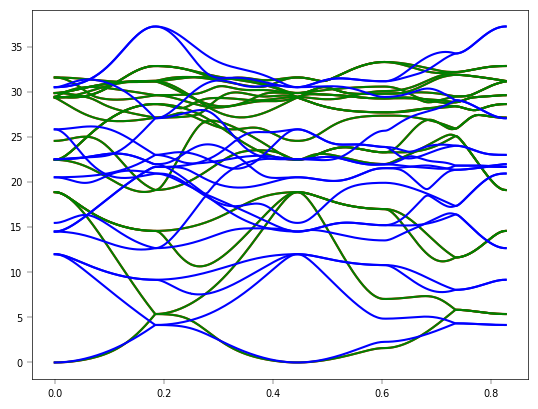

In [232]:
refeig = evals[:,:].T
plt.plot(eigens['xlist'],refeig - refeig.min() ,'r')
plt.plot(eigens['xlist'],eigs_np - eigs_np.min() ,'g')
plt.plot(eigens['xlist'],eigens['eigenvalues']-eigens['eigenvalues'].min(),'b')
plt.show()
